In [2]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import numpy as np
import librosa
import glob 
import librosa.display
import random
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation, Flatten 
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


In [14]:
voices = os.listdir('debate') 
voices = pd.DataFrame(voices, columns=['audio_file'])
voices['file'] = voices['audio_file'].str[:-4].astype('int64')
voices.head()

,audio_file,file
0,4666.wav,4666
1,3109.wav,3109
2,2217.wav,2217
3,5578.wav,5578
4,1078.wav,1078


In [101]:
labels = pd.read_csv('./speaker.csv', dtype = {'File':'int32', 'Biden':'int32','Trump':'int32','Wallace':'int32'})
labels['lable'] = labels['Biden'] + labels['Trump'] + labels['Wallace']
labels = labels[labels['lable'] == 1]

In [102]:
labels.head()

,File,Biden,Trump,Wallace,lable
0,1,0,0,1,1
1,2,0,0,1,1
2,3,0,0,1,1
3,4,0,0,1,1
4,5,0,0,1,1


In [103]:
labeled_voices = pd.merge(voices, labels, how='inner', left_on='file',right_on='File')

In [104]:
labeled_voices.head()

,audio_file,file,File,Biden,Trump,Wallace,lable
0,4666.wav,4666,4666,1,0,0,1
1,3109.wav,3109,3109,1,0,0,1
2,2217.wav,2217,2217,1,0,0,1
3,5578.wav,5578,5578,0,0,1,1
4,1078.wav,1078,1078,0,0,1,1


In [107]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('debate')+'/'+str(files.audio_file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.lable

    return mfccs, chroma, mel, contrast, tonnetz, label

In [108]:
startTime = datetime.now()
features_label = labeled_voices.apply(extract_features, axis=1)
print(datetime.now() - startTime)

/Users/cntuli/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/cntuli/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/cntuli/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=690
  n_fft, y.shape[-1]
/Users/cntuli/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=345
  n_fft, y.shape[-1]


0:15:06.887787


In [109]:
features_label

0       ([-361.13895, 91.08742, -14.342157, 41.452744,...
1       ([-332.97824, 100.985954, -18.147022, 26.95484...
2       ([-295.219, 110.81006, -5.81223, 21.848385, -4...
3       ([-375.28757, 102.866066, -42.474014, 30.69208...
4       ([-322.21542, 122.58064, -16.893541, 37.28262,...
5       ([-340.82117, 82.3733, -17.359371, 15.774056, ...
6       ([-347.056, 51.393642, -13.141288, 42.2513, 2....
7       ([-338.80234, 75.96545, -21.699778, 27.454435,...
8       ([-317.4329, 72.69052, 2.693752, 34.61321, 17....
9       ([-317.70297, 82.35551, 7.5576844, 37.894073, ...
10      ([-303.75375, 134.96312, -9.587165, 13.51186, ...
11      ([-259.1094, 68.44428, -20.818022, 23.641935, ...
12      ([-268.93167, 102.87571, -25.370861, 16.967558...
13      ([-358.0139, 127.05054, -8.840593, 16.027197, ...
14      ([-334.81302, 130.909, -26.949175, 43.886036, ...
15      ([-294.37686, 118.67031, -37.881714, 24.520885...
16      ([-302.21936, 65.39562, -3.8728445, 34.73826, ...
17      ([-353

In [110]:
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [111]:
features[0]

array([-3.61138947e+02,  9.10874176e+01, -1.43421574e+01,  4.14527435e+01,
        2.94684620e+01,  2.45124006e+00, -2.46153755e+01, -8.34459305e+00,
       -2.46191578e+01, -7.09217548e+00, -2.49976425e+01, -1.00292330e+01,
       -1.57277584e+01, -1.12099218e+01, -1.17369356e+01, -4.27719450e+00,
       -1.41287842e+01,  3.00077844e+00, -6.54266644e+00,  2.56348580e-01,
       -6.57356596e+00, -2.23494744e+00, -8.95378399e+00, -5.74844837e+00,
       -7.69453096e+00, -3.35167551e+00, -9.63597393e+00, -8.29237175e+00,
       -5.70785284e+00, -5.90263653e+00, -2.55990720e+00,  3.97251487e-01,
        2.95042014e+00,  2.19157100e+00,  3.20177054e+00,  7.20846534e-01,
       -1.50561482e-01, -3.03306073e-01,  2.92335391e-01,  1.10380620e-01,
        5.76098621e-01,  5.59436262e-01,  5.42225420e-01,  5.57507813e-01,
        6.20740414e-01,  6.40863836e-01,  6.25089288e-01,  6.38182938e-01,
        6.79731607e-01,  6.17005050e-01,  5.53462863e-01,  5.49084783e-01,
        1.38515153e-03,  

In [112]:
X = np.array(features)

In [113]:
def encode_speakers(biden, trump, wallace):
    encoded = 0
    
    if biden == 1:
        encoded = 1
    elif trump == 1:
        encoded = 2
    else:
        encoded = 3
    
    return encoded

In [114]:
y = labeled_voices.apply(lambda row: encode_speakers(row['Biden'],row['Trump'],row['Wallace']), axis = 1)

In [115]:
#labeled_voices.head()
y.head(20)

0     1
1     1
2     1
3     3
4     3
5     2
6     2
7     1
8     1
9     2
10    1
11    2
12    2
13    1
14    3
15    3
16    2
17    1
18    1
19    2
dtype: int64

In [116]:
y = np.array(y.values)

In [117]:
labelEncoder = LabelEncoder()
y = utils.to_categorical(labelEncoder.fit_transform(y))

In [118]:
X.shape

(4541, 193)

In [119]:
y.shape

(4541, 3)

In [120]:
scalar = StandardScaler()

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=1) 

In [122]:
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

In [156]:
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.25))    

model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [157]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/100
13/13 [==============================] - 0s 11ms/step - loss: 0.9979 - accuracy: 0.5510 - val_loss: 0.5449 - val_accuracy: 0.8365
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6073 - accuracy: 0.7575 - val_loss: 0.3454 - val_accuracy: 0.9188
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4590 - accuracy: 0.8161 - val_loss: 0.2462 - val_accuracy: 0.9366
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4144 - accuracy: 0.8265 - val_loss: 0.2045 - val_accuracy: 0.9544
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3443 - accuracy: 0.8613 - val_loss: 0.1865 - val_accuracy: 0.9577
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3187 - accuracy: 0.8610 - val_loss: 0.1766 - val_accuracy: 0.9600
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3033 - accuracy: 0.8745 - val_loss: 0.1651 - val_accuracy: 0.9566
Epoch 8/100


Epoch 59/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0471 - accuracy: 0.9837 - val_loss: 0.2612 - val_accuracy: 0.9677
Epoch 60/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0482 - accuracy: 0.9818 - val_loss: 0.2669 - val_accuracy: 0.9633
Epoch 61/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9843 - val_loss: 0.2981 - val_accuracy: 0.9655
Epoch 62/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0551 - accuracy: 0.9805 - val_loss: 0.2933 - val_accuracy: 0.9588
Epoch 63/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0435 - accuracy: 0.9871 - val_loss: 0.3034 - val_accuracy: 0.9611
Epoch 64/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0475 - accuracy: 0.9853 - val_loss: 0.3069 - val_accuracy: 0.9622
Epoch 65/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0425 - accuracy: 0.9859 - val_loss: 0.3098 - val_accuracy: 0.9588
Epoch 

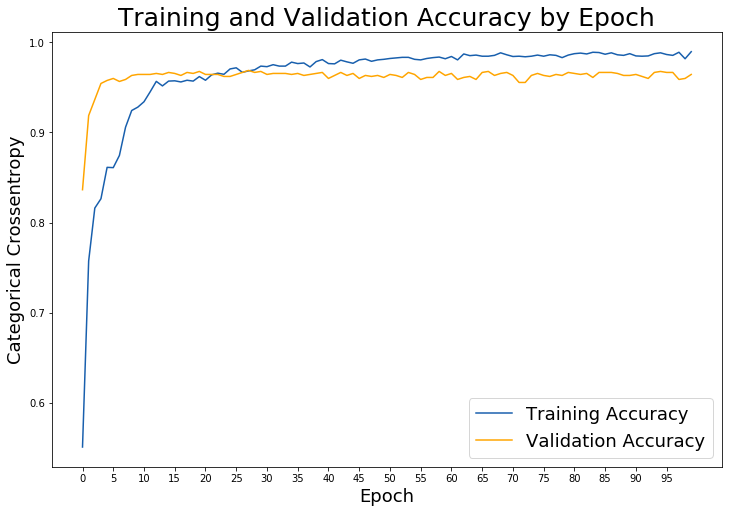

In [158]:
# Check out our train accuracy and validation accuracy over epochs.
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);
plt.show()

In [159]:
preds = model.predict_classes(X_test)

In [160]:
preds = labelEncoder.inverse_transform(preds)

/Users/cntuli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [135]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [161]:
df_test = pd.DataFrame(y_test, columns = ['Biden','Trump','Wallace']) 
df_test['Preds'] = preds

In [138]:
df_test

,Biden,Trump,Wallace,Preds
0,0.0,0.0,1.0,3
1,0.0,1.0,0.0,2
2,1.0,0.0,0.0,1
3,1.0,0.0,0.0,1
4,0.0,1.0,0.0,2
5,1.0,0.0,0.0,1
6,0.0,1.0,0.0,2
7,1.0,0.0,0.0,1
8,1.0,0.0,0.0,1
9,0.0,1.0,0.0,2


In [162]:
accurate = df_test[(((df_test['Wallace'] == 1) & (df_test['Preds'] == 3)) | \
        ((df_test['Biden'] == 1) & (df_test['Preds'] == 1)) | \
        ((df_test['Trump'] == 1) & (df_test['Preds'] == 2)))]

In [163]:
round(len(accurate)/len(df_test),3)

0.954

In [165]:
to_reshape = pd.read_csv('./speaker.csv', dtype = {'File':'int32', 'Biden':'int32','Trump':'int32','Wallace':'int32'})

In [166]:
reshaped_long = pd.melt(to_reshape, id_vars=['File'], value_vars=['Biden', 'Trump', 'Wallace'])

In [167]:
reshaped_long.head()

,File,variable,value
0,1,Biden,0
1,2,Biden,0
2,3,Biden,0
3,4,Biden,0
4,5,Biden,0


In [168]:
reshaped_long.to_csv('long_speaker.csv')